In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import scipy.signal as sig


In [2]:
Sr_i = 625
Sr_o = 48
vl = Sr_i * 48
vl

30000

In [3]:
# sample input signal -- at 10 kHz 
f_i = 10
w_i = 2 * np.pi * f_i
t = np.arange(vl)
s_i = np.exp(t * 1j * w_i / Sr_i)

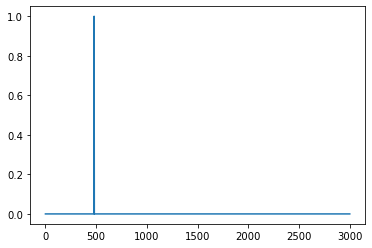

In [4]:
plt.plot(np.abs(np.fft.fft(s_i)/30000)[0:3000])

In [5]:
def makeLPF(cutoff, rate, length, taps):
    fdi = np.zeros(length) * 1j
    co_idx = int(length * cutoff / float(rate))
    print(co_idx)
    fdi[0:co_idx] = 1 + 0j
    fdi[co_idx:co_idx+20] = np.linspace(1, 0, 20)
    fdi[int(length/2):] = np.flip(fdi[0:int(length/2)])
    
    tdi = np.fft.ifft(fdi)
    #plt.plot(tdi[0:200], label='pos')
    #plt.plot(tdi[-200:], label='neg')
    #print(tdi[-10:])
    # window it
    win = sig.windows.blackman(taps, sym=False)
    #win = np.ones(taps)
    tidx = int(taps/2)
    #plt.plot(win)
    
    tdi[tidx:taps] = tdi[0:tidx+1]
    tdi[0:tidx] = np.flip(tdi[1:tidx+1])
    plt.plot(tdi, label='prewin')
    tdi[0:taps] = tdi[0:taps]*win
    plt.plot(tdi, label='shift')
    
    tdi[taps:] = 0 + 0j
    tdi = np.real(tdi)
    fo = np.fft.fft(tdi)

    return fo, tdi, fdi
    

2112


/usr/lib64/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


array([0.09552207, 0.11883622, 0.13495087, 0.14124673, 0.13664254,
       0.12184091])

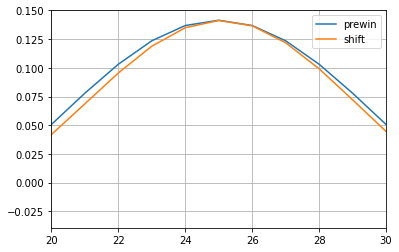

In [6]:
fo2, tdi2, fdi2 = makeLPF(44, 625, vl, 51)
#plt.plot(sig.windows.hamming(41, sym=True))
#plt.plot(tdi[0:160])
#plt.plot(tdi2[0:160])
plt.xlim(20,30)
#plt.ylim(-0.025,0.025)
#plt.plot(tdi2[-160:])
plt.grid()
plt.legend()
tdi2[22:28]

In [37]:
def FDResamplerGross(U,D,inb):
    # first calculate the LCM of the U/D spec
    from math import gcd
    g = gcd(U,D)
    
    in_blen = inb.size

    # output buffer length has to be large enough that
    # it is an even number of chunks at either sample rate. 
    if U > D: 
        in_blen_is_good = is_multiple(in_blen, D)
    else 
        in_blen_is_good = is_multiple(in_blen, U)
    if !in_blen_is_good:
        return -1
    

    # now transform
    finbuf = np.fft.fft(inb)
    
    # do the OBVIOUS and grossly sub-optimal thing. 
    nbuf = np.zeros(blen * U) * 1j
    blh = int((blen + 1) /2)
    bhh = blen - blh
    nbuf[0:blh] = finbuf[0:blh]
    nbuf[-bhh:] = finbuf[-bhh:]
    # now cut the low part off
    olen = int(blen * U / D)
    olh = int((olen + 1)/ 2)
    ohh = olen - olh
    out = np.zeros(olen) * 1j
    out[0:olh] = nbuf[0:olh]
    out[-ohh:] = nbuf[-ohh:]
    print("blen = %d olen = %d" % (blen, olen))
    # now invert
    return np.fft.ifft(out)

In [173]:
def isMultiple(a, b):
    adb = int(a / b)
    print("a = %d b = %d adb = %f a * adb %f" % (a, b, adb, (a * adb)))
    return (b * adb) == a

def FDResampler(U,D,inb):
    # first calculate the LCM of the U/D spec
    in_len = inb.size
 
    in_blen_is_good = isMultiple(in_len, D)

    
    if not in_blen_is_good:
        print("in_blen %d is not a good multiple U = %d D = %d" % (in_len, D, U))
        return -1 

    fin = np.fft.fft(inb)
    
    # start simple : two cases
    if U > D: 
        out_len = int(U * in_len / D)
        fout = np.zeros(out_len) * 1j
        olh = int((in_len + 1) / 2)
        ohh = in_len - olh
        fout[0:olh] = fin[0:olh]
        fout[-ohh:] = fin[-ohh:]
    elif U < D:
        print('U %d in_len %d D %d U*in_len/D = %f' % (U, in_len, D, (U*in_len)/D))
        out_len = int(U * in_len / D)
        print("out_len = %d" % out_len)
        fout = np.zeros(out_len) * 1j
        olh = int((out_len + 1)/ 2)
        ohh = out_len - olh
        fout[0:olh] = fin[0:olh]
        fout[-ohh:] = fin[-ohh:]
    else:
        return inb
    


    # now invert
    return (U / D) * np.fft.ifft(fout)

In [182]:
tv = np.arange(1250)
U=48
D=625
f1 = np.exp(1j * tv * np.pi/32)
f2 = FDResampler(U,D, f1)
f1.size, f2.size

a = 1250 b = 625 adb = 2.000000 a * adb 2500.000000
U 48 in_len 1250 D 625 U*in_len/D = 96.000000
out_len = 96


(1250, 96)

(0.0, 1.0)

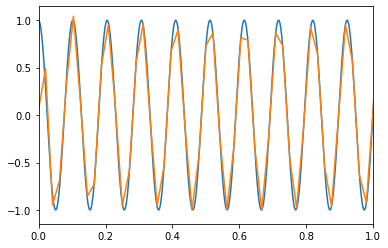

In [183]:
plt.plot(np.arange(f1.size) / 625, f1)
plt.plot(np.arange(f2.size) / 48,  f2)
plt.xlim(0,1)

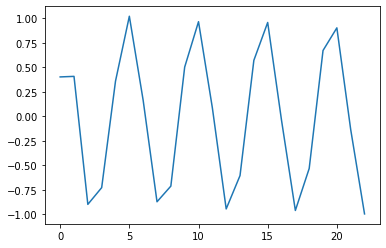

In [176]:
plt.plot(tv[0:23],np.real(f2[0:23]))

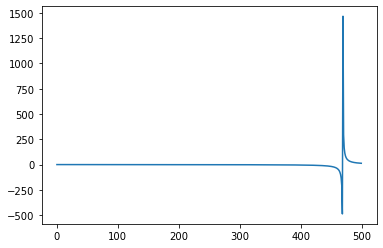

In [177]:
plt.plot(np.real(np.fft.fft(f2)[0:500]))

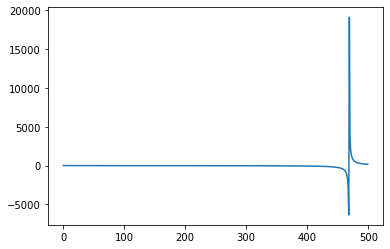

In [178]:
plt.plot(np.real(np.fft.fft(f1)[0:500]))

In [180]:
tv = np.arange(2304)
U=625
D=48
f1 = np.exp(1j * tv * np.pi/32)
f2 = FDResampler(U,D, f1)
tv,f1,f1.size,f2,f2.size # f1.size, f2.size

a = 2304 b = 48 adb = 48.000000 a * adb 110592.000000


(array([   0,    1,    2, ..., 2301, 2302, 2303]),
 array([1.        +0.j        , 0.99518473+0.09801714j,
        0.98078528+0.19509032j, ..., 0.95694034-0.29028468j,
        0.98078528-0.19509032j, 0.99518473-0.09801714j]),
 2304,
 array([1.        +1.40241939e-30j, 0.99997158+7.53975093e-03j,
        0.9998863 +1.50790732e-02j, ..., 0.99974419-2.26175383e-02j,
        0.9998863 -1.50790732e-02j, 0.99997158-7.53975093e-03j]),
 30000)

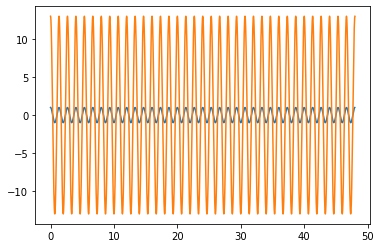

In [181]:
plt.plot(np.arange(f1.size) / 48, f1)
plt.plot(np.arange(f2.size) / 625, (625 / 48) * f2)